In [2]:
import pytorch_lightning as pl
from models.LEARN import LEARN_pl
from models.LEARN_LongNet2 import LEARN_LongNet_pl
from models.LEARN_Longformer import LEARN_Longformer_pl
from models.LEARN_Nys import LEARN_Nys_pl
from models.LEARN_Mamba import LEARN_Mamba_pl
from models.RegFormer import RegFormer_pl
from modules.reconstructor import reconstructor, reconstructor_loss
import torch
from torchmetrics.image import StructuralSimilarityIndexMeasure 
from torchmetrics.image import PeakSignalNoiseRatio
from CTSlice_Provider_dl import CTSlice_Provider
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import gc

#region: function
def to_batch_tensor(x, device):
    if torch.is_tensor(x):
        t = x.float()
    else:
        t = torch.from_numpy(x).float()
    if t.ndim == 2:
        t = t.unsqueeze(0)
    return t.unsqueeze(0).to(device)

def add_psnr_ssim_text(ax, psnr, ssim):
    ax.text(
        0.96, 0.96,
        f'PSNR/SSIM: {psnr:.2f}/{ssim:.2f}',
        color='white',
        fontsize=16,
        ha='right',
        va='top',
        transform=ax.transAxes,
        bbox=dict(facecolor='black', alpha=0.6, pad=5)
    )

def add_inset_zoom(ax, arr, box, zoom_ratio=0.3):
    x, y, w, h = box
    zoomed_img = arr[y:y+h, x:x+w]
    axins = inset_axes(
        ax,
        width=f"{int(zoom_ratio*100)}%",
        height=f"{int(zoom_ratio*100)}%",
        loc='lower left',
        borderpad=0,
        bbox_to_anchor=(0, 0, 1, 1),
        bbox_transform=ax.transAxes
    )
    axins.imshow(zoomed_img, cmap='gray')
    axins.set_xticks([])
    axins.set_yticks([])
    zoom_rect = patches.Rectangle((0, 0), w, h, linewidth=2, edgecolor='yellow', facecolor='none')
    axins.add_patch(zoom_rect)

#endregion

# === Main code ===
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

num_view = 32
input_size = 256
path_dir = "/data/uittogether/LuuTru/Thanhld/split_dl/"
transform = transforms.Compose([transforms.Resize(input_size)])
folder = 'DeepLesion'####################################################################################

titles = ['Ground truth', 'FBP', 'LEARN \n NystromFormer self-attention', 'LEARN \n Longformer self-attention', 'LEARN \n LongNet self-attention', 'LEARN \n SSM', 'LEARN' , 'RegFormer', 'DuDoTrans']

ssim_metric = StructuralSimilarityIndexMeasure().to(device)
psnr_metric = PeakSignalNoiseRatio().to(device)
# region: NOISE 0
poission_level = 0
dataset = CTSlice_Provider(base_path=path_dir, setting=f"numview_{num_view}_inputsize_256_noise_0_transform",
                           poission_level=poission_level, num_view=num_view, input_size=input_size,
                           transform=transform, test=True, num_select=-1)

model_learn = LEARN_pl.load_from_checkpoint(
    "/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/LEARN/saved_results_noise_2_dl/results_LEARN_30_iters_bs_1_view_32_noise_0_transform/epoch=35-val_psnr=41.7198.ckpt",
    map_location=device)
model_learn.eval().to(device)

model_longnet = LEARN_LongNet_pl.load_from_checkpoint(
    "/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/LEARN_LongNet/saved_results_noise_2_dl/results_LEARN_14_iters_bs_1_view_32_noise_0_transform/epoch=45-val_psnr=38.3784.ckpt",
    map_location=device)
model_longnet.eval().to(device)

model_long = LEARN_Longformer_pl.load_from_checkpoint(
    "/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/LEARN_Longformer/saved_results_noise_2_dl_with_Longformer/results_LEARN_14_iters_bs_1_view_32_noise_0_transform/epoch=46-val_psnr=36.2320.ckpt",
    map_location=device)
model_long.eval().to(device)

model_nys = LEARN_Nys_pl.load_from_checkpoint(
    "/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/LEARN_Nystromformer/saved_results_noise_2_dl/results_LEARN_14_iters_bs_1_view_32_noise_0_transform_2_9M/epoch=45-val_psnr=40.4359.ckpt",
    map_location=device)
model_nys.eval().to(device)

model_mamba = LEARN_Mamba_pl.load_from_checkpoint(
    "/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/LEARN_Mamba/saved_results_noise_2_dl/results_LEARN_14_iters_bs_1_view_32_noise_0_transform/epoch=08-val_psnr=26.6002.ckpt",
    map_location=device)
model_mamba.eval().to(device)

model_reg = RegFormer_pl.load_from_checkpoint(
    "/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/RegFormer/saved_results_noise_2_dl/results_RegFormer_10_iters_bs_1_view_32_noise_0_transform/epoch=45-val_psnr=40.1836.ckpt",
    map_location=device)
model_reg.eval().to(device)

dataset_ddt = CTSlice_Provider(base_path=path_dir, setting=f"numview_{num_view}_inputsize_256_noise_0_transform",
                               poission_level=poission_level, num_view=num_view, input_size=input_size,
                               transform=transform, test=True, num_select=-1)
model_ddt = reconstructor(dataset_ddt)
model_ddt.eval().to(device)

ckpt_path = f"/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/DuDoTrans/results_dl/models_{num_view}_view_{poission_level}_noise/epoch_48iter1999.pth.tar"
checkpoint = torch.load(ckpt_path, map_location=device)
model_ddt.load_state_dict(checkpoint['reconstructor_state'])
print("Loaded DuDoTrans model from checkpoint.")

max_loops = 1
found = False

min_combined_diff = float('inf')
min_combined_idx = -1
min_psnr_diff = None
min_ssim_diff = None

# Giữ cache các giá trị metric đã tính cho mỗi ảnh
cache_metrics = {}

for loop_idx in range(max_loops):
    print(f"Vòng lặp thứ {loop_idx + 1} / {max_loops}")
    # for idx in range(len(dataset) - 150 , -1, -1):
    for idx in range(1):
        phantom_raw, fbp_raw, sino_raw = dataset[idx]

        phantom = to_batch_tensor(phantom_raw, device)
        fbp = to_batch_tensor(fbp_raw, device)
        sino = to_batch_tensor(sino_raw, device)

        with torch.no_grad():
            out_nys = model_nys(fbp, sino)
            out_reg = model_reg(fbp, sino)
            

        psnr_nys = psnr_metric(out_nys, phantom).item()
        ssim_nys = ssim_metric(out_nys, phantom).item()
        psnr_reg = psnr_metric(out_reg, phantom).item()
        ssim_reg = ssim_metric(out_reg, phantom).item()

        # Lưu vào cache
        cache_metrics[idx] = {
            'psnr_nys': psnr_nys,
            'ssim_nys': ssim_nys,
            'psnr_reg': psnr_reg,
            'ssim_reg': ssim_reg,
            'phantom': phantom,
            'fbp': fbp,
            'sino': sino,
            'out_nys': out_nys,
            'out_reg': out_reg,
            'phantom_raw': phantom_raw,
            'fbp_raw': fbp_raw,
            'sino_raw': sino_raw
        }

        # Kiểm tra nếu Nystrom > RegFormer và LEARN cả PSNR và SSIM
        if psnr_nys > psnr_reg  and ssim_nys > ssim_reg :
            print(f"Tìm thấy ảnh idx={idx} thỏa điều kiện tại vòng {loop_idx+1}:")
            print(f"PSNR Nystrom: {psnr_nys:.4f} > PSNR Reg: {psnr_reg:.4f}")
            print(f"SSIM Nystrom: {ssim_nys:.4f} > SSIM Reg: {ssim_reg:.4f}")
            found = True
            break

        # Cập nhật hiệu nhỏ nhất
        diff_psnr = abs(psnr_nys - psnr_reg)
        diff_ssim = abs(ssim_nys - ssim_reg)
        combined_diff = diff_psnr + diff_ssim

        if combined_diff < min_combined_diff:
            min_combined_diff = combined_diff
            min_combined_idx = idx
            min_psnr_diff = diff_psnr
            min_ssim_diff = diff_ssim
        print(f'idx = {idx}')

    if found:
        break
    else:
        print(f"Chưa tìm thấy ảnh thỏa điều kiện ở vòng {loop_idx+1}")

if not found:
    print("Không tìm thấy ảnh nào thỏa điều kiện sau 10 vòng.")
    print(f"Ảnh có hiệu PSNR + SSIM nhỏ nhất tại idx = {min_combined_idx}")
    print(f"Hiệu PSNR = {min_psnr_diff:.4f}, Hiệu SSIM = {min_ssim_diff:.4f}")

idx_final = min_combined_idx if not found else idx

# Lấy lại các tensor đã tính ở vòng lặp
phantom = cache_metrics[idx_final]['phantom']
fbp = cache_metrics[idx_final]['fbp']
sino = cache_metrics[idx_final]['sino']
out_nys = cache_metrics[idx_final]['out_nys']
out_reg = cache_metrics[idx_final]['out_reg']


phantom_cpu = to_batch_tensor(cache_metrics[idx_final]['phantom_raw'], 'cpu')
fbp_cpu = to_batch_tensor(cache_metrics[idx_final]['fbp_raw'], 'cpu')
sino_cpu = to_batch_tensor(cache_metrics[idx_final]['sino_raw'], 'cpu')

# Tính các model khác nếu cần
with torch.no_grad():
    y_hat_learn = model_learn(fbp, sino)
    y_hat_mamba = model_mamba(fbp, sino)
    y_hat_longnet, _ = model_longnet(fbp, sino)
    y_hat_long, _ = model_long(fbp, sino)
    _, _, _, y_hat_ddt = model_ddt(fbp, phantom, sino)

ssim_p_learn = ssim_metric(y_hat_learn, phantom).item()
psnr_p_learn = psnr_metric(y_hat_learn, phantom).item()

ssim_p_longnet = ssim_metric(y_hat_longnet, phantom).item()
psnr_p_longnet = psnr_metric(y_hat_longnet, phantom).item()

ssim_p_nys = cache_metrics[idx_final]['ssim_nys']
psnr_p_nys = cache_metrics[idx_final]['psnr_nys']

ssim_p_long = ssim_metric(y_hat_long, phantom).item()
psnr_p_long = psnr_metric(y_hat_long, phantom).item()

ssim_p_mamba = ssim_metric(y_hat_mamba, phantom).item()
psnr_p_mamba = psnr_metric(y_hat_mamba, phantom).item()

ssim_p_reg = cache_metrics[idx_final]['ssim_reg']
psnr_p_reg = cache_metrics[idx_final]['psnr_reg']

ssim_p_ddt = ssim_metric(y_hat_ddt, phantom).item()
psnr_p_ddt = psnr_metric(y_hat_ddt, phantom).item()

imgs_0 = [
    phantom, fbp, out_nys, y_hat_long, y_hat_longnet, y_hat_mamba, y_hat_learn, out_reg, y_hat_ddt
]
psnr_list_0 = [
    None, None, psnr_p_nys, psnr_p_long, psnr_p_longnet, psnr_p_mamba, psnr_p_learn, psnr_p_reg, psnr_p_ddt
]
ssim_list_0 = [
    None, None, ssim_p_nys, ssim_p_long, ssim_p_longnet, ssim_p_mamba, ssim_p_learn, ssim_p_reg, ssim_p_ddt
]

print(f"Kết quả cuối cùng của noise {poission_level} tại idx = {idx_final}: PSNR_nys={psnr_p_nys:.4f}, SSIM_nys={ssim_p_nys:.4f}")
# endregion

# region: NOISE 5e5
poission_level = 5e5
dataset = CTSlice_Provider(base_path=path_dir, setting=f"numview_{num_view}_inputsize_256_noise_0_transform",
                           poission_level=poission_level, num_view=num_view, input_size=input_size,
                           transform=transform, test=True, num_select=-1)

model_learn = LEARN_pl.load_from_checkpoint(
    "/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/LEARN/saved_results_noise_2_dl/results_LEARN_30_iters_bs_1_view_32_noise_500000.0_transform/epoch=07-val_psnr=35.3654.ckpt",
    map_location=device)
model_learn.eval().to(device)

model_longnet = LEARN_LongNet_pl.load_from_checkpoint(
    "/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/LEARN_LongNet/saved_results_noise_2_dl/results_LEARN_14_iters_bs_1_view_32_noise_500000.0_transform/epoch=46-val_psnr=37.8223.ckpt",
    map_location=device)
model_longnet.eval().to(device)

model_long = LEARN_Longformer_pl.load_from_checkpoint(
    "/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/LEARN_Longformer/saved_results_noise_2_dl_with_Longformer/results_LEARN_14_iters_bs_1_view_32_noise_500000.0_transform/epoch=33-val_psnr=35.2276.ckpt",
    map_location=device)
model_long.eval().to(device)

model_nys = LEARN_Nys_pl.load_from_checkpoint(
    "/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/LEARN_Nystromformer/saved_results_noise_2_dl/results_LEARN_14_iters_bs_1_view_32_noise_500000.0_transform_2_9M/epoch=45-val_psnr=39.1148.ckpt",
    map_location=device)
model_nys.eval().to(device)

model_mamba = LEARN_Mamba_pl.load_from_checkpoint(
    "/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/LEARN_Mamba/saved_results_noise_2_dl/results_LEARN_14_iters_bs_1_view_32_noise_500000.0_transform/epoch=08-val_psnr=26.3399.ckpt",
    map_location=device)
model_mamba.eval().to(device)

model_reg = RegFormer_pl.load_from_checkpoint(
    "/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/RegFormer/saved_results_noise_2_dl/results_RegFormer_10_iters_bs_1_view_32_noise_500000.0_transform/epoch=45-val_psnr=39.2371.ckpt",
    map_location=device)
model_reg.eval().to(device)

dataset_ddt = CTSlice_Provider(base_path=path_dir, setting=f"numview_{num_view}_inputsize_256_noise_0_transform",
                               poission_level=poission_level, num_view=num_view, input_size=input_size,
                               transform=transform, test=True, num_select=-1)
model_ddt = reconstructor(dataset_ddt)
model_ddt.eval().to(device)

ckpt_path = f"/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/DuDoTrans/results_dl/models_{num_view}_view_{poission_level}_noise/epoch_48iter1999.pth.tar"
checkpoint = torch.load(ckpt_path, map_location=device)
model_ddt.load_state_dict(checkpoint['reconstructor_state'])
print("Loaded DuDoTrans model from checkpoint.")

max_loops = 1
found = False

min_combined_diff = float('inf')
min_combined_idx = -1
min_psnr_diff = None
min_ssim_diff = None

# Giữ cache các giá trị metric đã tính cho mỗi ảnh
cache_metrics = {}

for loop_idx in range(max_loops):
    print(f"Vòng lặp thứ {loop_idx + 1} / {max_loops}")
    # for idx in range(len(dataset) - 200 , -1, -1):
    for idx in range(1):
        phantom_raw, fbp_raw, sino_raw = dataset[idx]

        phantom = to_batch_tensor(phantom_raw, device)
        fbp = to_batch_tensor(fbp_raw, device)
        sino = to_batch_tensor(sino_raw, device)

        with torch.no_grad():
            out_nys = model_nys(fbp, sino)
            out_reg = model_reg(fbp, sino)
            

        psnr_nys = psnr_metric(out_nys, phantom).item()
        ssim_nys = ssim_metric(out_nys, phantom).item()
        psnr_reg = psnr_metric(out_reg, phantom).item()
        ssim_reg = ssim_metric(out_reg, phantom).item()

        # Lưu vào cache
        cache_metrics[idx] = {
            'psnr_nys': psnr_nys,
            'ssim_nys': ssim_nys,
            'psnr_reg': psnr_reg,
            'ssim_reg': ssim_reg,
            'phantom': phantom,
            'fbp': fbp,
            'sino': sino,
            'out_nys': out_nys,
            'out_reg': out_reg,
            'phantom_raw': phantom_raw,
            'fbp_raw': fbp_raw,
            'sino_raw': sino_raw
        }

        # Kiểm tra nếu Nystrom > RegFormer và LEARN cả PSNR và SSIM
        if psnr_nys > psnr_reg  and ssim_nys > ssim_reg :
            print(f"Tìm thấy ảnh idx={idx} thỏa điều kiện tại vòng {loop_idx+1}:")
            print(f"PSNR Nystrom: {psnr_nys:.4f} > PSNR Reg: {psnr_reg:.4f}")
            print(f"SSIM Nystrom: {ssim_nys:.4f} > SSIM Reg: {ssim_reg:.4f}")
            found = True
            break

        # Cập nhật hiệu nhỏ nhất
        diff_psnr = abs(psnr_nys - psnr_reg)
        diff_ssim = abs(ssim_nys - ssim_reg)
        combined_diff = diff_psnr + diff_ssim

        if combined_diff < min_combined_diff:
            min_combined_diff = combined_diff
            min_combined_idx = idx
            min_psnr_diff = diff_psnr
            min_ssim_diff = diff_ssim
        print(f'idx = {idx}')

    if found:
        break
    else:
        print(f"Chưa tìm thấy ảnh thỏa điều kiện ở vòng {loop_idx+1}")

if not found:
    print("Không tìm thấy ảnh nào thỏa điều kiện sau 10 vòng.")
    print(f"Ảnh có hiệu PSNR + SSIM nhỏ nhất tại idx = {min_combined_idx}")
    print(f"Hiệu PSNR = {min_psnr_diff:.4f}, Hiệu SSIM = {min_ssim_diff:.4f}")

idx_final = min_combined_idx if not found else idx

# Lấy lại các tensor đã tính ở vòng lặp
phantom = cache_metrics[idx_final]['phantom']
fbp = cache_metrics[idx_final]['fbp']
sino = cache_metrics[idx_final]['sino']
out_nys = cache_metrics[idx_final]['out_nys']
out_reg = cache_metrics[idx_final]['out_reg']


phantom_cpu = to_batch_tensor(cache_metrics[idx_final]['phantom_raw'], 'cpu')
fbp_cpu = to_batch_tensor(cache_metrics[idx_final]['fbp_raw'], 'cpu')
sino_cpu = to_batch_tensor(cache_metrics[idx_final]['sino_raw'], 'cpu')

# Tính các model khác nếu cần
with torch.no_grad():
    y_hat_learn = model_learn(fbp, sino)
    y_hat_mamba = model_mamba(fbp, sino)
    y_hat_longnet, _ = model_longnet(fbp, sino)
    y_hat_long, _ = model_long(fbp, sino)
    _, _, _, y_hat_ddt = model_ddt(fbp, phantom, sino)

ssim_p_learn = ssim_metric(y_hat_learn, phantom).item()
psnr_p_learn = psnr_metric(y_hat_learn, phantom).item()

ssim_p_longnet = ssim_metric(y_hat_longnet, phantom).item()
psnr_p_longnet = psnr_metric(y_hat_longnet, phantom).item()

ssim_p_nys = cache_metrics[idx_final]['ssim_nys']
psnr_p_nys = cache_metrics[idx_final]['psnr_nys']

ssim_p_long = ssim_metric(y_hat_long, phantom).item()
psnr_p_long = psnr_metric(y_hat_long, phantom).item()

ssim_p_mamba = ssim_metric(y_hat_mamba, phantom).item()
psnr_p_mamba = psnr_metric(y_hat_mamba, phantom).item()

ssim_p_reg = cache_metrics[idx_final]['ssim_reg']
psnr_p_reg = cache_metrics[idx_final]['psnr_reg']

ssim_p_ddt = ssim_metric(y_hat_ddt, phantom).item()
psnr_p_ddt = psnr_metric(y_hat_ddt, phantom).item()

imgs_5e5 = [
    phantom, fbp, out_nys, y_hat_long, y_hat_longnet, y_hat_mamba, y_hat_learn, out_reg, y_hat_ddt
]
psnr_list_5e5 = [
    None, None, psnr_p_nys, psnr_p_long, psnr_p_longnet, psnr_p_mamba, psnr_p_learn, psnr_p_reg, psnr_p_ddt
]
ssim_list_5e5 = [
    None, None, ssim_p_nys, ssim_p_long, ssim_p_longnet, ssim_p_mamba, ssim_p_learn, ssim_p_reg, ssim_p_ddt
]

print(f"Kết quả cuối cùng của noise {poission_level} tại idx = {idx_final}: PSNR_nys={psnr_p_nys:.4f}, SSIM_nys={ssim_p_nys:.4f}")
# endregion

# region: NOISE 1e6
poission_level = 1e6
dataset = CTSlice_Provider(base_path=path_dir, setting=f"numview_{num_view}_inputsize_256_noise_0_transform",
                           poission_level=poission_level, num_view=num_view, input_size=input_size,
                           transform=transform, test=True, num_select=-1)

model_learn = LEARN_pl.load_from_checkpoint(
    "/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/LEARN/saved_results_noise_2_dl/results_LEARN_30_iters_bs_1_view_32_noise_1000000.0_transform/epoch=45-val_psnr=40.2374.ckpt",
    map_location=device)
model_learn.eval().to(device)

model_longnet = LEARN_LongNet_pl.load_from_checkpoint(
    "/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/LEARN_LongNet/saved_results_noise_2_dl/results_LEARN_14_iters_bs_1_view_32_noise_1000000.0_transform/epoch=46-val_psnr=38.4334.ckpt",
    map_location=device)
model_longnet.eval().to(device)

model_long = LEARN_Longformer_pl.load_from_checkpoint(
    "/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/LEARN_Longformer/saved_results_noise_2_dl_with_Longformer/results_LEARN_14_iters_bs_1_view_32_noise_1000000.0_transform/epoch=31-val_psnr=35.8869.ckpt",
    map_location=device)
model_long.eval().to(device)

model_nys = LEARN_Nys_pl.load_from_checkpoint(
    "/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/LEARN_Nystromformer/saved_results_noise_2_dl/results_LEARN_14_iters_bs_1_view_32_noise_1000000.0_transform_2_9M/epoch=45-val_psnr=39.6366.ckpt",
    map_location=device)
model_nys.eval().to(device)

model_mamba = LEARN_Mamba_pl.load_from_checkpoint(
    "/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/LEARN_Mamba/saved_results_noise_2_dl/results_LEARN_14_iters_bs_1_view_32_noise_1000000.0_transform/epoch=08-val_psnr=26.4543.ckpt",
    map_location=device)
model_mamba.eval().to(device)

model_reg = RegFormer_pl.load_from_checkpoint(
    "/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/RegFormer/saved_results_noise_2_dl/results_RegFormer_10_iters_bs_1_view_32_noise_1000000.0_transform/epoch=45-val_psnr=39.5972.ckpt",
    map_location=device)
model_reg.eval().to(device)

dataset_ddt = CTSlice_Provider(base_path=path_dir, setting=f"numview_{num_view}_inputsize_256_noise_0_transform",
                               poission_level=poission_level, num_view=num_view, input_size=input_size,
                               transform=transform, test=True, num_select=-1)
model_ddt = reconstructor(dataset_ddt)
model_ddt.eval().to(device)

ckpt_path = f"/data/uittogether/LuuTru/Thanhld/CT-Reconstruction/DuDoTrans/results_dl/models_{num_view}_view_{poission_level}_noise/epoch_48iter1999.pth.tar"
checkpoint = torch.load(ckpt_path, map_location=device)
model_ddt.load_state_dict(checkpoint['reconstructor_state'])
print("Loaded DuDoTrans model from checkpoint.")

max_loops = 1
found = False

min_combined_diff = float('inf')
min_combined_idx = -1
min_psnr_diff = None
min_ssim_diff = None

# Giữ cache các giá trị metric đã tính cho mỗi ảnh
cache_metrics = {}

for loop_idx in range(max_loops):
    print(f"Vòng lặp thứ {loop_idx + 1} / {max_loops}")
    # for idx in range(len(dataset) - 170 , -1, -1):
    for idx in range(1):
        phantom_raw, fbp_raw, sino_raw = dataset[idx]

        phantom = to_batch_tensor(phantom_raw, device)
        fbp = to_batch_tensor(fbp_raw, device)
        sino = to_batch_tensor(sino_raw, device)

        with torch.no_grad():
            out_nys = model_nys(fbp, sino)
            out_reg = model_reg(fbp, sino)
            

        psnr_nys = psnr_metric(out_nys, phantom).item()
        ssim_nys = ssim_metric(out_nys, phantom).item()
        psnr_reg = psnr_metric(out_reg, phantom).item()
        ssim_reg = ssim_metric(out_reg, phantom).item()

        # Lưu vào cache
        cache_metrics[idx] = {
            'psnr_nys': psnr_nys,
            'ssim_nys': ssim_nys,
            'psnr_reg': psnr_reg,
            'ssim_reg': ssim_reg,
            'phantom': phantom,
            'fbp': fbp,
            'sino': sino,
            'out_nys': out_nys,
            'out_reg': out_reg,
            'phantom_raw': phantom_raw,
            'fbp_raw': fbp_raw,
            'sino_raw': sino_raw
        }

        # Kiểm tra nếu Nystrom > RegFormer và LEARN cả PSNR và SSIM
        if psnr_nys > psnr_reg  and ssim_nys > ssim_reg :
            print(f"Tìm thấy ảnh idx={idx} thỏa điều kiện tại vòng {loop_idx+1}:")
            print(f"PSNR Nystrom: {psnr_nys:.4f} > PSNR Reg: {psnr_reg:.4f}")
            print(f"SSIM Nystrom: {ssim_nys:.4f} > SSIM Reg: {ssim_reg:.4f}")
            found = True
            break

        # Cập nhật hiệu nhỏ nhất
        diff_psnr = abs(psnr_nys - psnr_reg)
        diff_ssim = abs(ssim_nys - ssim_reg)
        combined_diff = diff_psnr + diff_ssim

        if combined_diff < min_combined_diff:
            min_combined_diff = combined_diff
            min_combined_idx = idx
            min_psnr_diff = diff_psnr
            min_ssim_diff = diff_ssim
        print(f'idx = {idx}')

    if found:
        break
    else:
        print(f"Chưa tìm thấy ảnh thỏa điều kiện ở vòng {loop_idx+1}")

if not found:
    print("Không tìm thấy ảnh nào thỏa điều kiện sau 10 vòng.")
    print(f"Ảnh có hiệu PSNR + SSIM nhỏ nhất tại idx = {min_combined_idx}")
    print(f"Hiệu PSNR = {min_psnr_diff:.4f}, Hiệu SSIM = {min_ssim_diff:.4f}")

idx_final = min_combined_idx if not found else idx

# Lấy lại các tensor đã tính ở vòng lặp
phantom = cache_metrics[idx_final]['phantom']
fbp = cache_metrics[idx_final]['fbp']
sino = cache_metrics[idx_final]['sino']
out_nys = cache_metrics[idx_final]['out_nys']
out_reg = cache_metrics[idx_final]['out_reg']


phantom_cpu = to_batch_tensor(cache_metrics[idx_final]['phantom_raw'], 'cpu')
fbp_cpu = to_batch_tensor(cache_metrics[idx_final]['fbp_raw'], 'cpu')
sino_cpu = to_batch_tensor(cache_metrics[idx_final]['sino_raw'], 'cpu')

# Tính các model khác nếu cần
with torch.no_grad():
    y_hat_learn = model_learn(fbp, sino)
    y_hat_mamba = model_mamba(fbp, sino)
    y_hat_longnet, _ = model_longnet(fbp, sino)
    y_hat_long, _ = model_long(fbp, sino)
    _, _, _, y_hat_ddt = model_ddt(fbp, phantom, sino)

ssim_p_learn = ssim_metric(y_hat_learn, phantom).item()
psnr_p_learn = psnr_metric(y_hat_learn, phantom).item()

ssim_p_longnet = ssim_metric(y_hat_longnet, phantom).item()
psnr_p_longnet = psnr_metric(y_hat_longnet, phantom).item()

ssim_p_nys = cache_metrics[idx_final]['ssim_nys']
psnr_p_nys = cache_metrics[idx_final]['psnr_nys']

ssim_p_long = ssim_metric(y_hat_long, phantom).item()
psnr_p_long = psnr_metric(y_hat_long, phantom).item()

ssim_p_mamba = ssim_metric(y_hat_mamba, phantom).item()
psnr_p_mamba = psnr_metric(y_hat_mamba, phantom).item()

ssim_p_reg = cache_metrics[idx_final]['ssim_reg']
psnr_p_reg = cache_metrics[idx_final]['psnr_reg']

ssim_p_ddt = ssim_metric(y_hat_ddt, phantom).item()
psnr_p_ddt = psnr_metric(y_hat_ddt, phantom).item()

imgs_1e6 = [
    phantom, fbp, out_nys, y_hat_long, y_hat_longnet, y_hat_mamba, y_hat_learn, out_reg, y_hat_ddt
]
psnr_list_1e6 = [
    None, None, psnr_p_nys, psnr_p_long, psnr_p_longnet, psnr_p_mamba, psnr_p_learn, psnr_p_reg, psnr_p_ddt
]
ssim_list_1e6 = [
    None, None, ssim_p_nys, ssim_p_long, ssim_p_longnet, ssim_p_mamba, ssim_p_learn, ssim_p_reg, ssim_p_ddt
]

print(f"Kết quả cuối cùng của noise {poission_level} tại idx = {idx_final}: PSNR_nys={psnr_p_nys:.4f}, SSIM_nys={ssim_p_nys:.4f}")
# endregion



Using device: cuda:1
poission_level 0
A100 GPU detected, using flash attention if input tensor is on cuda
poission_level 0
1
1
Loaded DuDoTrans model from checkpoint.
Vòng lặp thứ 1 / 1
Tìm thấy ảnh idx=0 thỏa điều kiện tại vòng 1:
PSNR Nystrom: 41.7981 > PSNR Reg: 41.5197
SSIM Nystrom: 0.9767 > SSIM Reg: 0.9742
attn_weights torch.Size([1, 4, 16, 1024, 1024])
attn_weights torch.Size([1, 4, 16, 1024, 1024])
attn_weights torch.Size([1, 4, 16, 1024, 1024])
attn_weights torch.Size([1, 4, 16, 1024, 1024])
attn_weights torch.Size([1, 4, 16, 1024, 1024])
attn_weights torch.Size([1, 4, 16, 1024, 1024])
attn_weights torch.Size([1, 4, 16, 1024, 1024])
attn_weights torch.Size([1, 4, 16, 1024, 1024])
attn_weights torch.Size([1, 4, 16, 1024, 1024])
attn_weights torch.Size([1, 4, 16, 1024, 1024])
attn_weights torch.Size([1, 4, 16, 1024, 1024])
attn_weights torch.Size([1, 4, 16, 1024, 1024])
attn_weights torch.Size([1, 4, 16, 1024, 1024])
attn_weights torch.Size([1, 4, 16, 1024, 1024])
Kết quả cuối c

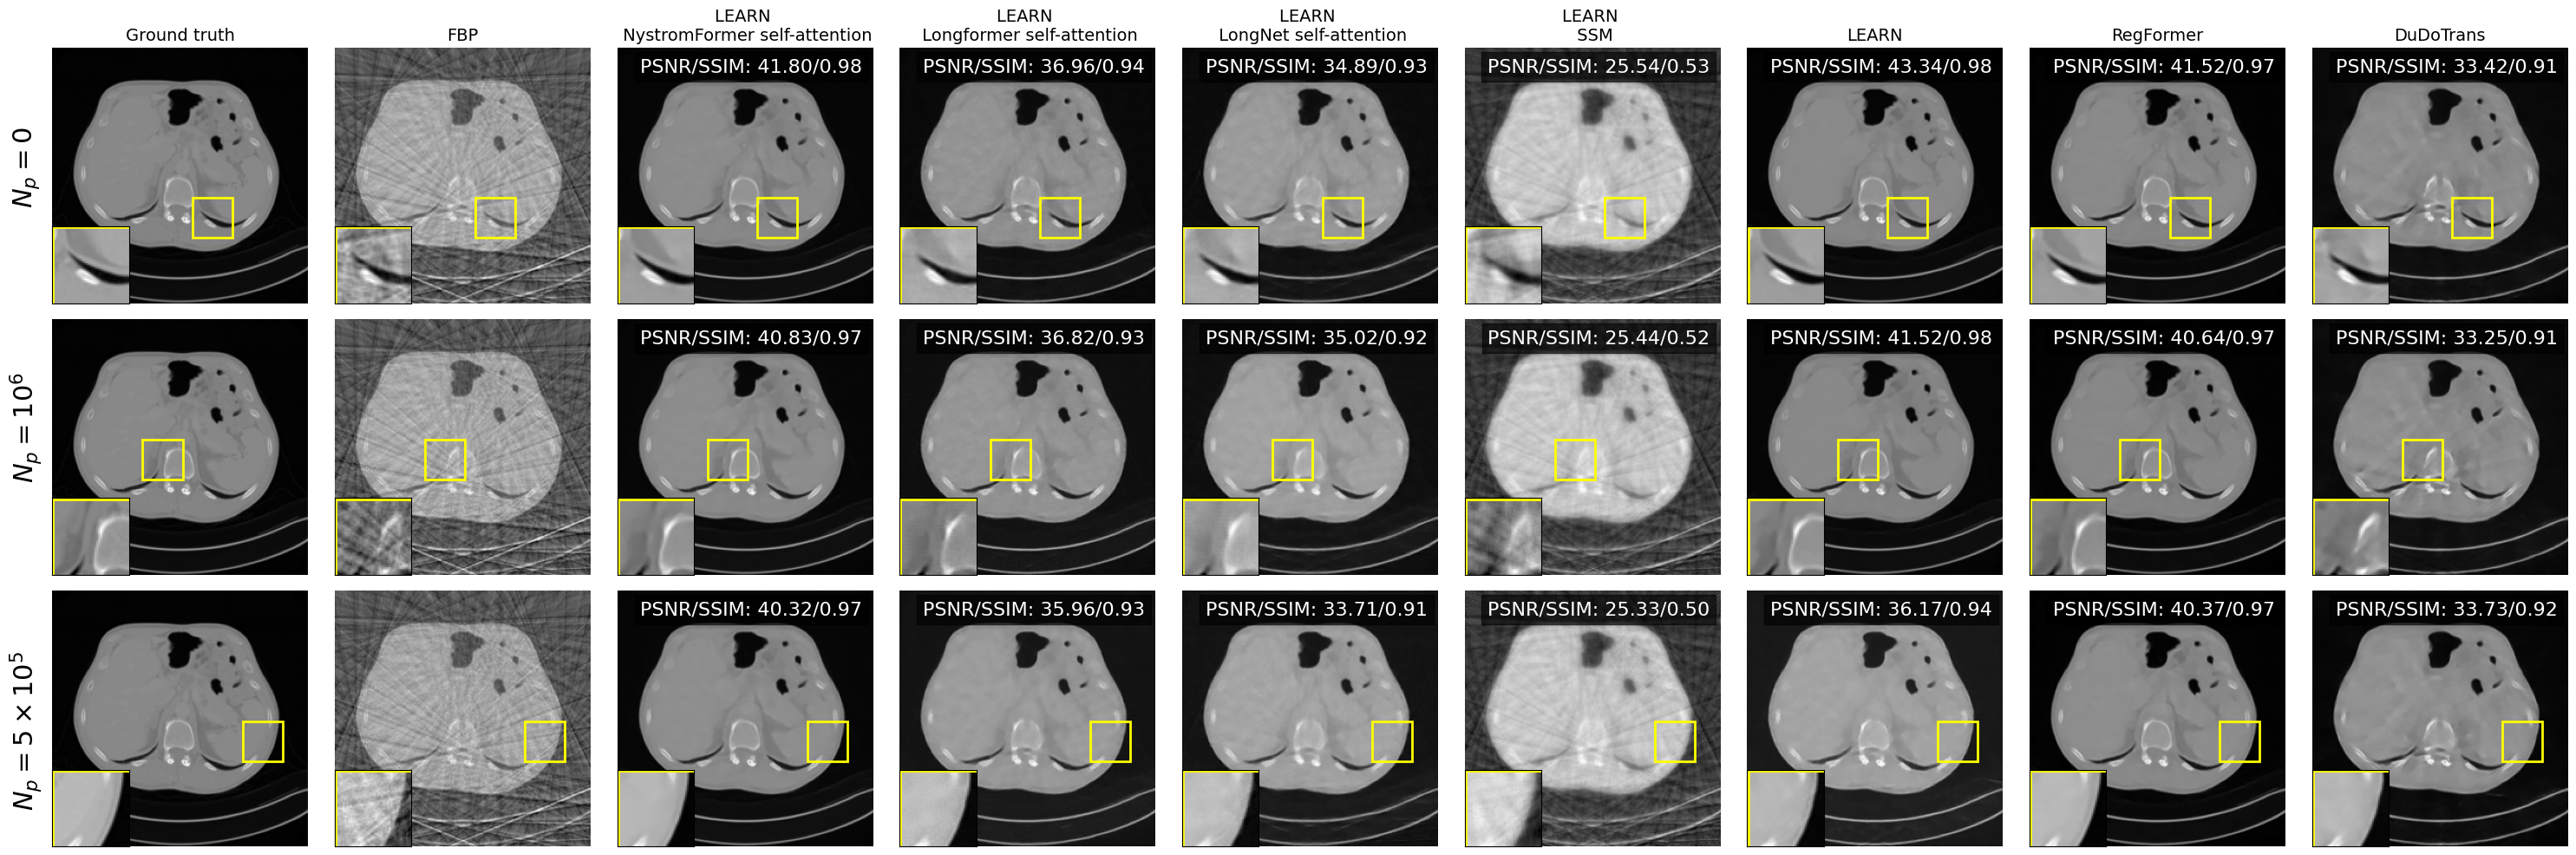

In [20]:
# region: VISUALIZE
datasets = [
    {  # N_p=0
        'label': '$N_p = 0$',
        'imgs': imgs_0,    
        'titles': titles,  
        'psnr_list': psnr_list_0,
        'ssim_list': ssim_list_0,
    },
    {  # N_p=1e6
        'label': '$N_p = 10^6$',
        'imgs': imgs_1e6,    
        'titles': titles,  
        'psnr_list': psnr_list_1e6,
        'ssim_list': ssim_list_1e6,
    },    
    {  # N_p=5e5
        'label': '$N_p = 5 \\times 10^5$',
        'imgs': imgs_5e5,    
        'titles': titles,  
        'psnr_list': psnr_list_5e5,
        'ssim_list': ssim_list_5e5,
    },
]

yellow_boxes1 = [(140, 150, 40, 40)]  # Thay đổi vị trí cho hàng 1
yellow_boxes2 = [(90, 120, 40, 40)]  # Thay đổi vị trí cho hàng 2
yellow_boxes3 = [(190, 130, 40, 40)]  # Thay đổi vị trí cho hàng 3

# fig, axes = plt.subplots(3, 9, figsize=(30, 10))
# plt.subplots_adjust(hspace=0.05, wspace=0.001)  # Giảm thêm khoảng cách giữa các cột

fig, axes = plt.subplots(3, 9, figsize=(29.3, 10))  # Thêm số cột và tăng chiều ngang của figure
plt.subplots_adjust(hspace=0.05, wspace=0.01)  # Giảm khoảng cách giữa các cột



for row_idx, data in enumerate(datasets):
    imgs = data['imgs']
    titles = data['titles']
    psnr_list = data['psnr_list']
    ssim_list = data['ssim_list']

    # Chọn yellow_boxes khác nhau cho mỗi hàng
    if row_idx == 0:
        yellow_boxes = yellow_boxes1
    elif row_idx == 1:
        yellow_boxes = yellow_boxes2
    else:
        yellow_boxes = yellow_boxes3

    for col_idx in range(9):
        ax = axes[row_idx, col_idx]
        arr = imgs[col_idx].detach().cpu().squeeze().numpy()  # luôn chuyển về CPU trước khi vẽ
        ax.imshow(arr, cmap='gray')
        if row_idx == 0:
            ax.set_title(titles[col_idx], fontsize=14)
        ax.axis('off')

        for (x, y, w, h) in yellow_boxes:
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='yellow', facecolor='none')
            ax.add_patch(rect)

        if psnr_list[col_idx] is not None and ssim_list[col_idx] is not None:
            add_psnr_ssim_text(ax, psnr_list[col_idx], ssim_list[col_idx])

        add_inset_zoom(ax, arr, yellow_boxes[0])

    # Thêm nhãn dọc cho mỗi hàng
    label_ys = [0.8, 0.50, 0.15]
    fig.text(
        -0.005,  # vị trí ngang (gần sát trái)
        label_ys[row_idx],  # vị trí dọc chính giữa hàng
        data['label'],
        va='center',
        ha='center',
        rotation='vertical',
        fontsize=22
    )
plt.tight_layout()
plt.savefig(f'./Visualization/{folder}/views_{num_view}_dl.png', bbox_inches='tight')
#endregion